###  Autor: Lilian Rebeca Carrera Lemus 
No. Carnet: 20008077  


# Práctica No. 2 - Regresión Polinomial & Feature engineering

### Parte 1 - Modelo exponencial de covid-19 usando feature-eng

Usando el ejemplo de covid-19 en el notebook de feature-eng (https://colab.research.google.com/drive/1sJV2HG7tQgCGKES3-dIclzHQJ9qAWB3b?usp=sharing) crear un modelo de covid-19 para Guatemala.

* Convertir la fecha a un entero "número de día", por ejemplo si se usan datos desde el 22 de abril, este es el día 0, el 23 es el día 1.
* Aplicar regresión lineal sobre la variable "Confirmed" transformada.
* Una vez entrenado el modelo usarlo para aproximar la cantidad de casos confirmados para el 30 de mayo. Se debe reportar la cantidad de casos, no la cantidad transformada obtenida.

In [1]:
#Importamos las librerías que utilizaremos en esta práctica
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime as dt

In [2]:
if tf.__version__.startswith("2."):
    import tensorflow.compat.v1 as tf
    tf.compat.v1.disable_v2_behavior()
    tf.compat.v1.disable_eager_execution()
    print("Enabled compatitility to tf1.x")

Instructions for updating:
non-resource variables are not supported in the long term
Enabled compatitility to tf1.x


In [3]:
#Cargamos los datos del archivo a utilizar
datos_covid = pd.read_csv('covid_19_clean_complete.csv')
datos_covid

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,NaN,Afghanistan,33.000000,65.000000,1/22/20,0,0,0
1,NaN,Albania,41.153300,20.168300,1/22/20,0,0,0
2,NaN,Algeria,28.033900,1.659600,1/22/20,0,0,0
3,NaN,Andorra,42.506300,1.521800,1/22/20,0,0,0
4,NaN,Angola,-11.202700,17.873900,1/22/20,0,0,0
...,...,...,...,...,...,...,...,...
29035,NaN,Western Sahara,24.215500,-12.885800,5/10/20,6,0,5
29036,NaN,Sao Tome and Principe,0.186360,6.613081,5/10/20,208,5,4
29037,NaN,Yemen,15.552727,48.516388,5/10/20,51,8,1
29038,NaN,Comoros,-11.645500,43.333300,5/10/20,11,1,0


### Limpieza de Datos

Para empezar se realizará una limpieza de datos, esto con el objetivo de que al momento de hacer el entrenamiento de nuestro modelo, le proporcionemos los mejores datos posibles, es decir datos limpios.

 **a)Eliminar observaciones no deseadas**  
Como primer paso para la limpieza de datos se eliminarán las observaciones no deseadas del su conjunto de datos, lo cual incluye observaciones duplicadas  o  irrelevantes. En este caso solo necesitamos los valores correspondientes al país de Guatemala y se eliminarán las observaciones correspondientes a otros Países, ya que nuestro modelo busca realizar predicciones solamente para Guatemala.


In [4]:
df_covid = datos_covid[datos_covid["Country/Region"] == 'Guatemala'].copy()
df_covid

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
123,NaN,Guatemala,15.7835,-90.2308,1/22/20,0,0,0
387,NaN,Guatemala,15.7835,-90.2308,1/23/20,0,0,0
651,NaN,Guatemala,15.7835,-90.2308,1/24/20,0,0,0
915,NaN,Guatemala,15.7835,-90.2308,1/25/20,0,0,0
1179,NaN,Guatemala,15.7835,-90.2308,1/26/20,0,0,0
...,...,...,...,...,...,...,...,...
27843,NaN,Guatemala,15.7835,-90.2308,5/6/20,798,21,86
28107,NaN,Guatemala,15.7835,-90.2308,5/7/20,832,23,90
28371,NaN,Guatemala,15.7835,-90.2308,5/8/20,900,24,101
28635,NaN,Guatemala,15.7835,-90.2308,5/9/20,967,24,104


**b)Filtrar valores atípicos no deseados:**  
Se filtrarán los valores no deseados, ya que estos pueden causar problemas con nuestro modelo.
En este caso se tomarán solo los valores confirmados mayores a 0, para que nos queden los días desde donde iniciaron los casos confirmados en Guatemala.

In [5]:
df_covid = df_covid[df_covid["Confirmed"] > 0]
df_covid.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
13851,NaN,Guatemala,15.7835,-90.2308,3/14/20,1,0,0
14115,NaN,Guatemala,15.7835,-90.2308,3/15/20,1,0,0
14379,NaN,Guatemala,15.7835,-90.2308,3/16/20,2,1,0
14643,NaN,Guatemala,15.7835,-90.2308,3/17/20,6,1,0
14907,NaN,Guatemala,15.7835,-90.2308,3/18/20,6,1,0


### Feature engineering

Después de la limpieza de datos realizaremos ingeniería de características para ayudar a nuestros algoritmos y mejorar el rendimiento del modelo.

 **a)Seleccionar**  
 Como primer paso vamos a seleccionar solamente las caracteristicas que vamos a utilizar y que nos interesan, que son relevantes para este modelo. En este caso solamente vamos a seleccionar la fecha y los casos confirmados, ya que no necesitamos el País porque en el paso anterior filtramos solamente Guatemala.

In [6]:
#Seleccionamos solo las columnas que nos interesan para este ejercicio
df_covid = df_covid.loc[:,["Date", "Confirmed"]]
df_covid.head()

,Date,Confirmed
13851,3/14/20,1
14115,3/15/20,1
14379,3/16/20,2
14643,3/17/20,6
14907,3/18/20,6


**Eliminación de observaciones con valores nulos**  
 Como ya hemos seleccionado la información que vamos a utilizar, se procedió  a verificar que no existan valores nulos o NA, ya que la falta de datos resulta en un problema en el aprendizaje de nuestro modelo. En ete caso confirmamos que no hay valores nulos o NA en nuestros datos.  
 Este paso va en la limpieza de datos, sin embargo como en este ejercicio ya se nos indicó que variables especificas utilizar, hasta ahora confirmo que no hayan valores faltantes.

In [7]:
# Verificamos la información de cada columna
#Podemos observar que no hay datos nulos
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58 entries, 13851 to 28899
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       58 non-null     object
 1   Confirmed  58 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


 **b)Crear y transformar**  
 Se crearán nuevas features derivadas de las existentes y otras se transformarán con el objetivo es facilitar y hacer que los algoritmos funcionen y sean óptimos a través de estas transformaciónes de los datos de entrada. 
 
En este caso:
* Creamos una nueva columna de día, en la cual se transforma de la columna de fecha a números enteros, así la fecha de 14 de marzo será el día 0 y se le sumará 1 al cada uno de los días que le siguen.
* Transformaremos la variable objetivo de datos confirmados a Logaritmo Natural 

In [8]:
#Se crea la nueva columnna de día, derivada o basandonos en la columna de fecha
df_covid['Day'] = np.linspace(start= 0, stop = len(df_covid["Date"]), num = len(df_covid['Date']), endpoint=False, dtype = int)
df_covid.head() 

,Date,Confirmed,Day
13851,3/14/20,1,0
14115,3/15/20,1,1
14379,3/16/20,2,2
14643,3/17/20,6,3
14907,3/18/20,6,4


In [9]:
#El último día para el cual se tiene información disponible es para el 10 de mayo 2020
ultimo_dia = df_covid[-1:]
ultimo_dia

,Date,Confirmed,Day
28899,5/10/20,1052,57


**Análisis Exploratorio de Datos**  
 Se procedió a realizar un poco de análisis exploratorio en los datos seleccionados para ver el comportamiento de los mismos.


Text(0.5, 1.0, 'Casos confirmados por número de día en Guatemala')

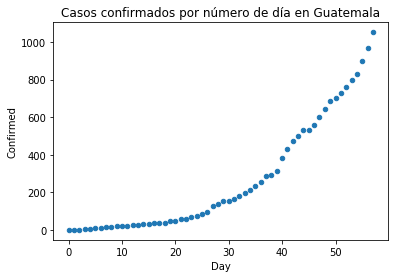

In [10]:
df_covid.plot.scatter(x ="Day",y="Confirmed")
plt.title('Casos confirmados por número de día en Guatemala')

La idea para este problema es entrenar un modelo de regresión líneal para predecir el comportamiento de los casos confirmados de Covid19 en Guatemala para los proximos días. Sin embargo, podemos obserevar en la gráfica que el comportamiento o patrón de los datos no es del todo líneal, por lo cual aplicaremos el Logartimo Natural a nuestra variable objetivo de casos confirmados

Text(0.5, 1.0, 'Ln de Casos confirmados por número de día en Guatemala')

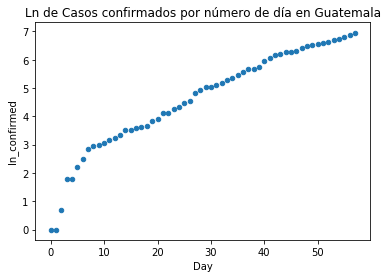

In [11]:
df_covid["ln_confirmed"] = np.log(df_covid["Confirmed"])
df_covid.plot.scatter(x ="Day",y="ln_confirmed")
plt.title('Ln de Casos confirmados por número de día en Guatemala')

Observamos ahora que con esta transformación, los datos siguen un comportamiento con un patrón lineal.
Se procederá también a filtrar y quitar los primeros ocho días, ya que por ser los primeros días presentan un comportamiento atípico.

Text(0.5, 1.0, 'Ln de Casos confirmados por número de día en Guatemala')

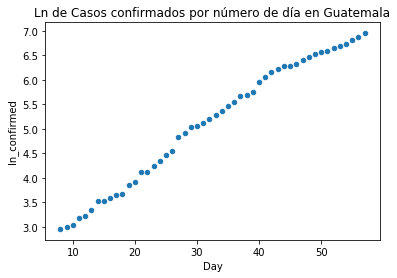

In [36]:
df_covid_10 = df_covid[df_covid.Day >= 8]
df_covid_10.plot.scatter(x ="Day",y="ln_confirmed")
plt.title('Ln de Casos confirmados por número de día en Guatemala')

In [13]:
#Con esto finalizamos Feature engineering y ya tenemos listo nuestro dataset de entrada para entrenar el modelo de Regresión Lineal
df_covid_10.head()

,Date,Confirmed,Day,ln_confirmed
15963,3/22/20,19,8,2.944439
16227,3/23/20,20,9,2.995732
16491,3/24/20,21,10,3.044522
16755,3/25/20,24,11,3.178054
17019,3/26/20,25,12,3.218876


### Implementación de Modelo de Regresión Lineal

In [14]:
#Aplicando reutilización de código por medio del uso de programación orientada a objetos para crear el modelo
class RegresionLineal:    
    def __init__(self,n):
         # Vector de parametros, para pendiente e intercepto
        self.parametros = tf.get_variable("parametros",dtype=tf.float32,shape=[1,n],initializer=tf.zeros_initializer())
    
    def __call__(self,x):
        #Calculamos "y" estimada
        return tf.matmul(self.parametros,x, name="MatMul")
    
    #Calculo del error MSE mediante la función de costo
    def error(self, x, y):
        mse = 0.5 * tf.reduce_mean(tf.math.square(y - self(x)))
        return mse

    def actualizar(self,x,y,learning_rate):
        with tf.name_scope("funcion_costo"):
            error = self.error(x, y)
            #Scalar para utilizar en tensorboard
            error_summary = tf.summary.scalar("error_summary", error)
                                     
        #Actualizamos los parametros por medio de Gradient Descent
        gradiente = tf.gradients(error, [self.parametros], name="gradientes")
        actualizacion_parametros = tf.assign(self.parametros, self.parametros -learning_rate*gradiente[0], name="actualizar")
        
        return actualizacion_parametros, error, error_summary

In [15]:
#Aplicando reutilización de código por medio del uso de programación orientada a objetos p/definir la fun. de entrenamiento
def entrenamiento_rl(x, y, lr, epochs, imprimir_error, gpolinomio):
    # Definimos el string de configuración para cada experimiento
    string_conf = './logs/'+ dt.datetime.now().strftime("%Y%m%d-%H%M%S") +"_lr="+str(lr)+ "_epochs="+str(epochs)+ "_polinomio_grado=" + str(gpolinomio)

    x_fil, x_col = np.shape(x)
    tf.reset_default_graph()
    g = tf.Graph()  #definición del grafo a usar
    
    with g.as_default():
        modelo = RegresionLineal(x_fil)
        # Definimos las entradas del grafo, los tensores para x y para y
        tensor_y = tf.placeholder(float,[x_col], name="Y")
        tensor_x = tf.placeholder(float,[x_fil,x_col], name="X")
        
        # Realizamos el entrenamiento mediante el metodo actualizar
        actualizar_parametros = modelo.actualizar(tensor_x, tensor_y, lr)
        
        # Escribimos el archivo para tensorboard
        writer = tf.summary.FileWriter(string_conf, g)
        
        with tf.train.MonitoredSession() as session:
            dict_parametros = {tensor_x:x, tensor_y:y}
            for i in range(1, epochs+1):   
                # Ejecutamos el entrenamiento
                entrenamiento = session.run(actualizar_parametros, feed_dict = dict_parametros)
            
                if (i)%imprimir_error == 0:
                    # Calculamos los parametros para cada epoch que se va a imprimir
                    parametros = session.run(modelo.parametros, feed_dict = dict_parametros)
                    # Agregamos un escalar para monitorear el MSE posteriormente en tensorboard
                    writer.add_summary(entrenamiento[2], i)
                    print("Iteración:",i,", Parametros:", parametros,", Error:",entrenamiento[1])
                    print("_______________________________________________________________________________________________________")
            
            return parametros, entrenamiento[1]
            writer.close()

In [35]:
#Obtenemos los valores para "x" y ""y  del data frame de entrenamiento de covid
x = df_covid_10["Day"]
#Transformamos x para poder utilizarla en el modelo
x = np.array([np.ones_like(x),x], dtype = "float32")
y = df_covid_10["ln_confirmed"]

### Experimientos y Entrenamiento del Modelo  
Se realizan varios experimientos para encontrar el número óptimo para los hiper-parametros del modelo y así poder obtener el mejor modelo posible, que en este caso será el que presente un menor error (MSE)

In [22]:
#lr = 0.01, epochs= 10000
ml_parametros, MSE = entrenamiento_rl(x, y, 0.01, 10000,2000,1)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Iteración: 2000 , Parametros: [[nan nan]] , Error: nan
_______________________________________________________________________________________________________
Iteración: 4000 , Parametros: [[nan nan]] , Error: nan
_______________________________________________________________________________________________________
Iteración: 6000 , Parametros: [[nan nan]] , Error: nan
_______________________________________________________________________________________________________
Iteración: 8000 , Parametros: [[nan nan]] , Error: nan
_______________________________________________________________________________________________________
Iteración: 10000 , Parametros: [[nan nan]] , Error: nan
_______________________________________________________________________________________________________


In [23]:
#lr = 0.001, epochs= 1000
ml_parametros, MSE = entrenamiento_rl(x, y, 0.001, 1000,200,1)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Iteración: 200 , Parametros: [[0.07818374 0.14365079]] , Error: 0.41783643
_______________________________________________________________________________________________________
Iteración: 400 , Parametros: [[0.1502152 0.1417992]] , Error: 0.3918679
_______________________________________________________________________________________________________
Iteración: 600 , Parametros: [[0.21991396 0.14000757]] , Error: 0.3675541
_______________________________________________________________________________________________________
Iteración: 800 , Parametros: [[0.28735575 0.13827397]] , Error: 0.34478948
_______________________________________________________________________________________________________
Iteración: 1000 , Parametros: [[0.3526134  0.13659652]] , Error: 0.3234754
_____________________________________________________________________________________________

In [24]:
#lr = 0.0001, epochs= 1000
ml_parametros, MSE = entrenamiento_rl(x, y, 0.0001, 1000,200,1)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Iteración: 200 , Parametros: [[0.01129615 0.14537019]] , Error: 0.44258776
_______________________________________________________________________________________________________
Iteración: 400 , Parametros: [[0.01882572 0.14517656]] , Error: 0.4397511
_______________________________________________________________________________________________________
Iteración: 600 , Parametros: [[0.02633056 0.14498366]] , Error: 0.43693307
_______________________________________________________________________________________________________
Iteración: 800 , Parametros: [[0.03381073 0.14479141]] , Error: 0.43413344
_______________________________________________________________________________________________________
Iteración: 1000 , Parametros: [[0.0412663  0.14459978]] , Error: 0.43135232
_________________________________________________________________________________________

In [25]:
#lr = 0.001, epochs= 10000
ml_parametros, MSE = entrenamiento_rl(x, y, 0.001, 10000,2000,1)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Iteración: 2000 , Parametros: [[0.6485391  0.12898968]] , Error: 0.23562601
_______________________________________________________________________________________________________
Iteración: 4000 , Parametros: [[1.1124752  0.11706411]] , Error: 0.1269389
_______________________________________________________________________________________________________
Iteración: 6000 , Parametros: [[1.4462813  0.10848355]] , Error: 0.07067249
_______________________________________________________________________________________________________
Iteración: 8000 , Parametros: [[1.6864568  0.10230979]] , Error: 0.04154398
_______________________________________________________________________________________________________
Iteración: 10000 , Parametros: [[1.8592651  0.09786772]] , Error: 0.026464395
___________________________________________________________________________________

In [26]:
#lr = 0.001, epochs= 50000
ml_parametros, MSE = entrenamiento_rl(x, y, 0.001, 50000,10000,1)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Iteración: 10000 , Parametros: [[1.8592651  0.09786772]] , Error: 0.026464395
_______________________________________________________________________________________________________
Iteración: 20000 , Parametros: [[2.2170637  0.08867044]] , Error: 0.010880555
_______________________________________________________________________________________________________
Iteración: 30000 , Parametros: [[2.2860584  0.08689691]] , Error: 0.010301067
_______________________________________________________________________________________________________
Iteración: 40000 , Parametros: [[2.2993186  0.08655605]] , Error: 0.01027954
_______________________________________________________________________________________________________
Iteración: 50000 , Parametros: [[2.3018203  0.08649175]] , Error: 0.010278731
___________________________________________________________________________

In [27]:
#lr = 0.001, epochs= 100000
ml_parametros, MSE = entrenamiento_rl(x, y, 0.001, 100000,10000,1)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Iteración: 10000 , Parametros: [[1.8592651  0.09786772]] , Error: 0.026464395
_______________________________________________________________________________________________________
Iteración: 20000 , Parametros: [[2.2170637  0.08867044]] , Error: 0.010880555
_______________________________________________________________________________________________________
Iteración: 30000 , Parametros: [[2.2860584  0.08689691]] , Error: 0.010301067
_______________________________________________________________________________________________________
Iteración: 40000 , Parametros: [[2.2993186  0.08655605]] , Error: 0.01027954
_______________________________________________________________________________________________________
Iteración: 50000 , Parametros: [[2.3018203  0.08649175]] , Error: 0.010278731
___________________________________________________________________________

### Predicciones

Calculamos las predicciones, con los parametros obtenidos mediante el mejor modelo de acuerdo al entrenamiento.

In [30]:
#Parámetros del mejor modelo:
print("Parámetros Modelo: ", ml_parametros, "MSE: ", MSE)

Parámetros Modelo:  [[2.3018203  0.08649175]] MSE:  0.010278731


In [43]:
predicciones = ml_parametros[0][1] * df_covid_10['Day'] + ml_parametros[0][0]

Gráficamos los resultados obtenidos de las predicciones, tanto en Logartimo Natural que sería nuestra variable transformada, como también la salida final de la variable, la cual sería el número de casos confirmados.

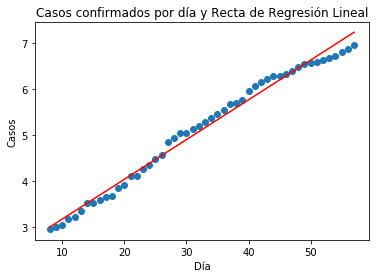

In [44]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(x=df_covid_10["Day"], y=df_covid_10["ln_confirmed"])
ax.plot(df_covid_10["Day"], predicciones, 'red')
ax.set_xlabel("Día")
ax.set_ylabel("Casos")
ax.set_title("Casos confirmados por día y Recta de Regresión Lineal")
ax.set_aspect('auto')
plt.show()

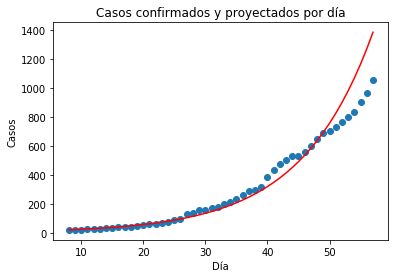

In [45]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(df_covid_10["Day"], df_covid_10["Confirmed"])
ax.plot(df_covid_10["Day"], np.exp(predicciones), 'red')
ax.set_xlabel("Día")
ax.set_ylabel("Casos")
ax.set_title("Casos confirmados y proyectados por día")
ax.set_aspect('auto')
plt.show()

### Conclusión:

Debido a que en el ejercicio se solicita realizar la predicción de los casos confirmados para el día 30 de mayo, procederemos a realizar el cálculo de las predicciones desde el día 0 hasta el día 78 (que sería el 30 de mayo).

In [48]:
#Obtenemos el total de predicciones hasta el día no.77 que sería el 30 de mayo
#(pero debemos tomar en cuenta que iniciamos en el día 0, por lo cual sería de 1 a 78)
Tprediction = ml_parametros[0][1] * np.linspace(1,78, 78) + ml_parametros[0][0]

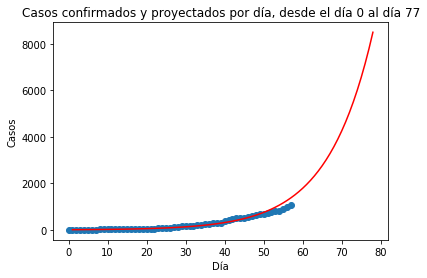

In [49]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(df_covid["Day"], df_covid["Confirmed"])
ax.plot(np.linspace(1,78,78), np.exp(Tprediction), 'red')
ax.set_xlabel("Día")
ax.set_ylabel("Casos")
ax.set_title("Casos confirmados y proyectados por día, desde el día 0 al día 77")
ax.set_aspect('auto')
plt.show()

In [50]:
#Predicción para el día 30 de mayo
prediccion_30mayo = np.exp(Tprediction[-1])
print("La predicción para el 30 de mayo es: ", np.round(prediccion_30mayo), " casos")

La predicción para el 30 de mayo es:  8503.0  casos


Según el modelo obtenido, la predicción para el 30 de mayo de 2020 es de 8,503 casos confirmados. Sin embargo, la información oficial de casos confirmados para ese día fue de 4,739 casos, por lo cual podemos decir que el modelo está bastante desfasado con respecto a los casos reales.

De acuerdo a los experimentos realizados, el modelo con el error más pequeño (MSE), se presenta al utilizar un **learning rate = 0.001 con 5000 iteraciones**. Lo cual corresponde a un **MSE = 0.010278731**

### Parte 2 - Modelo polinomial de calidad de vinos

Es permitido utilizar [sklearn.preprocessing.polynomialfeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)


### Instrucciones

1. Seleccionar y transformar(generando las combinaciones polinomiales para un polinomio de grado dos o tres a elección) las features que considere que son las mejores para predecir la calidad del vino, utilizar como minimo 2 features. Para seleccionar las features, hacer un analisis exploratorio por ejemplo(pero no limitado a ):  graficando y viendo la forma en que se comportan los datos.

 Por ejemplo, se tienen las features "a" y "b" y seleccionamos polinomio de grado 2, hacemos feature engineering para obtener :
 
 $[a,b,a^{2},b^{2},ab]$
 
 No olvidar el "bias" (parámetro multiplicado por 1) ,con lo cual el dataset puede quedar con las columnas:
 
 $[1,a,b,a^{2},b^{2},ab]$
2. Una vez transformada la data aplicar regresion lineal con las features polinomiales usando Tensorflow.

Requisitos adicionales:
* Se debe agregar al notebook un screenshot del grafo de tensorboard, simplificando(usando  names , y name_scope como visto en clase).

* Se debe generar un directorio de logs de tensorboard para cada corrida/experimento , con cada directorio identificando facilmente la configuración del experimento como visto en clase, por ejemplo para un experimento con learning rate = 0.1 , y polinomio grado 2  crear un directorio: lr=0.1_polinomio_grado=2. (Agregar al notebook un screenshot de estas gráficas)

* Concluir en markdown cual es el mejor modelo para este caso basado en la comparativa entre curvas de costo/error en tensorboard.

In [51]:
#Librerías a utilizar
import pandas as pd
import seaborn as sb
from sklearn.preprocessing import PolynomialFeatures
%load_ext tensorboard

In [52]:
#cargar datos
data = pd.read_csv('winequality-red.csv')

### Red Wine Quality Data

Se aplicará regresión para crear un modelo de la calidad de vino en función de características del mismo, siendo 1 el peor vino y 10 el mejor.

Variables de entrada:
1. fixed acidity 
2. volatile acidity 
3. citric acid 
4. residual sugar 
5. chlorides 
6. free sulfur dioxide 
7. total sulfur dioxide 
8. density 
9. pH 
10. sulphates 
11. alcohol 

Varaible a predecir: 
12. quality (puntuacion  entre 0 y 10) 



In [53]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [54]:
#Información de dataset
data.info() #verificamos las columnas, tipos de datos, si hay datos nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [55]:
'''Se dividen los datos de la siguiente manera:
80% de las filas serán datos de entrenamiento y 20% de las filas serán para pruebas '''

#Datos de entrenamiento
d_entrenamiento = int(0.8 * len(data))
df_entrenamiento = data[:d_entrenamiento]
#datos de validacion
df_validacion = data[d_entrenamiento:]

print('Longitud del data frame completo: ',len(data))
print('Longitud del data frame de entrenamiento: ',len(df_entrenamiento))
print('Longitud del data frame de validación: ',len(df_validacion))

Longitud del data frame completo:  1599
Longitud del data frame de entrenamiento:  1279
Longitud del data frame de validación:  320


### 1. Seleccionar y Transformar las Variables

#### Análisis exploratorio de datos

In [56]:
#Mediante la función "describe" de pandas podemos generar un resumen descriptivo de un  dataframe
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


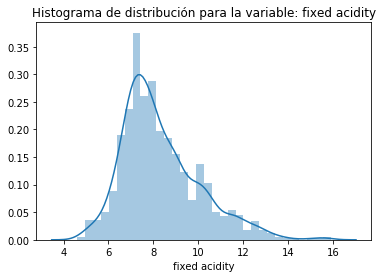

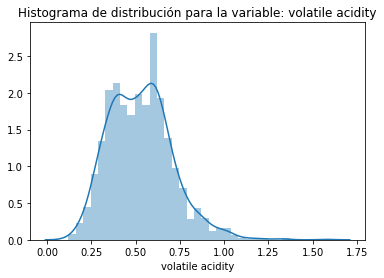

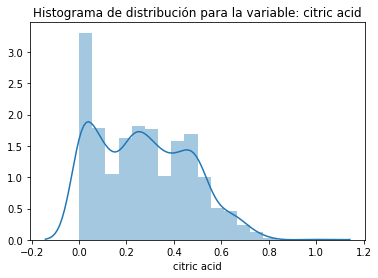

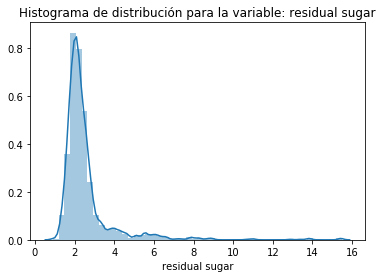

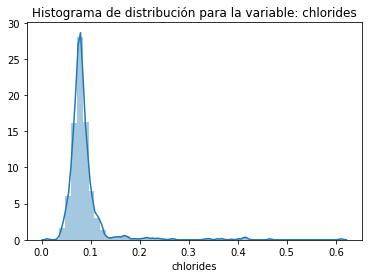

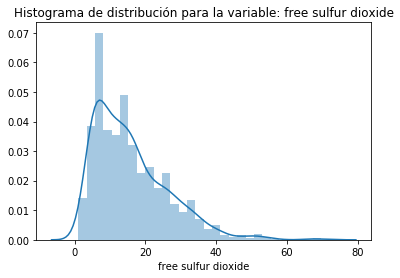

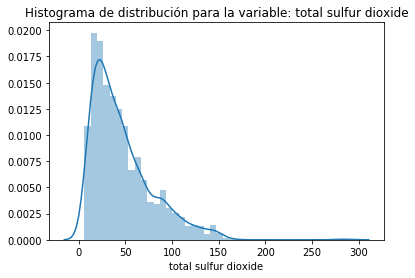

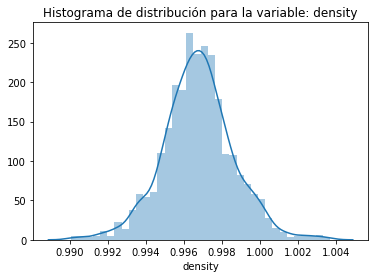

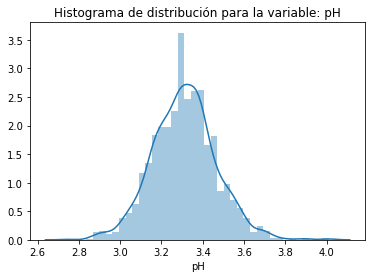

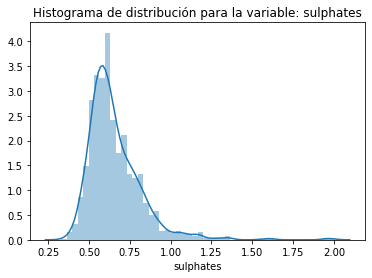

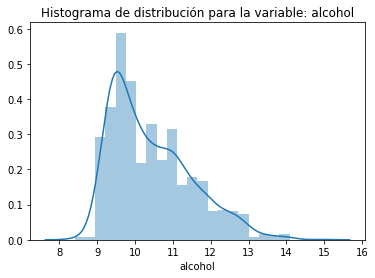

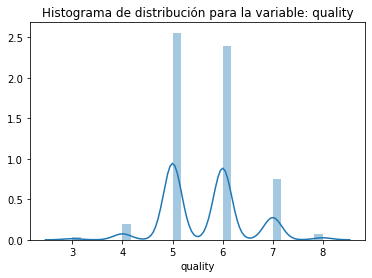

In [57]:
#Graficamos los histogramas para cada una de las variables con el objetivo de verifiar la forma de la distribución de cada
#variable

for i in range(0,len(data.columns)):
    nombre_var = str(data.columns[i])  
    titulo_g = "Histograma de distribución para la variable: " + nombre_var
    
    sb.distplot(data[data.columns[i]]).set_title(titulo_g)
    plt.show()

Se procede a determinar la correlación entre cada una de las variables independientes y la variable dependiente quality, para decidir cuales 2 o 3 variables independientes (features) utilizar en el modelo.

In [58]:
#Calculamos el coeficiente de correlación
df_correlacion = data.corr()
df_correlacion

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.256131,0.671703,0.114777,0.093705,-0.153794,-0.113181,0.668047,-0.682978,0.183006,-0.061668,0.124052
volatile acidity,-0.256131,1.000000,-0.552496,0.001918,0.061298,-0.010504,0.076470,0.022026,0.234937,-0.260987,-0.202288,-0.390558
citric acid,0.671703,-0.552496,1.000000,0.143577,0.203823,-0.060978,0.035533,0.364947,-0.541904,0.312770,0.109903,0.226373
residual sugar,0.114777,0.001918,0.143577,1.000000,0.055610,0.187049,0.203028,0.355283,-0.085652,0.005527,0.042075,0.013732
chlorides,0.093705,0.061298,0.203823,0.055610,1.000000,0.005562,0.047400,0.200632,-0.265026,0.371260,-0.221141,-0.128907
free sulfur dioxide,-0.153794,-0.010504,-0.060978,0.187049,0.005562,1.000000,0.667666,-0.021946,0.070377,0.051658,-0.069408,-0.050656
total sulfur dioxide,-0.113181,0.076470,0.035533,0.203028,0.047400,0.667666,1.000000,0.071269,-0.066495,0.042947,-0.205654,-0.185100
density,0.668047,0.022026,0.364947,0.355283,0.200632,-0.021946,0.071269,1.000000,-0.341699,0.148506,-0.496180,-0.174919
pH,-0.682978,0.234937,-0.541904,-0.085652,-0.265026,0.070377,-0.066495,-0.341699,1.000000,-0.196648,0.205633,-0.057731
sulphates,0.183006,-0.260987,0.312770,0.005527,0.371260,0.051658,0.042947,0.148506,-0.196648,1.000000,0.093595,0.251397


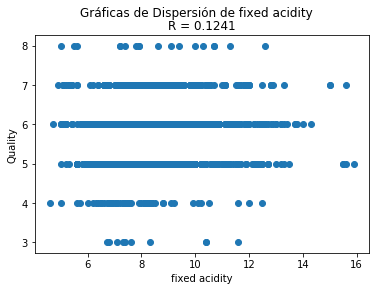

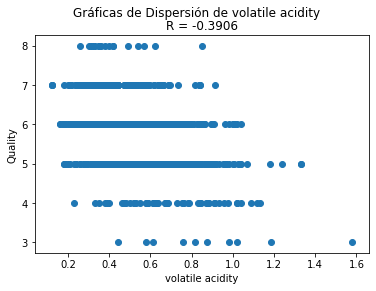

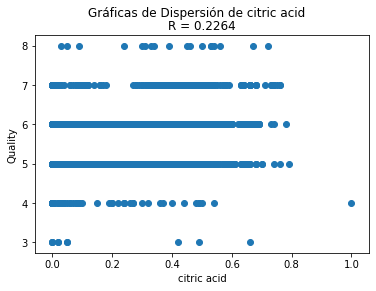

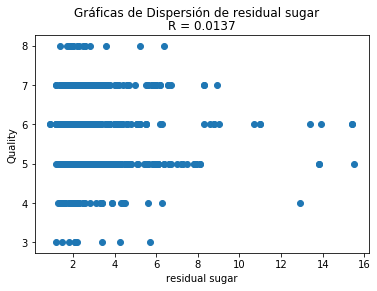

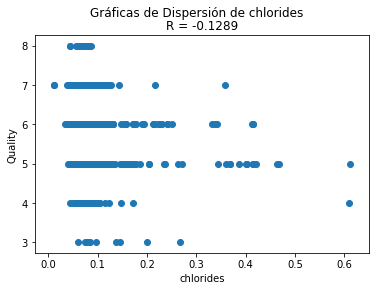

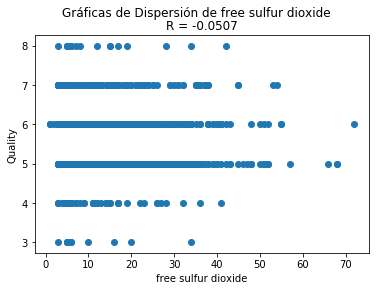

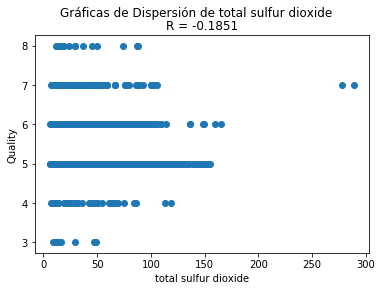

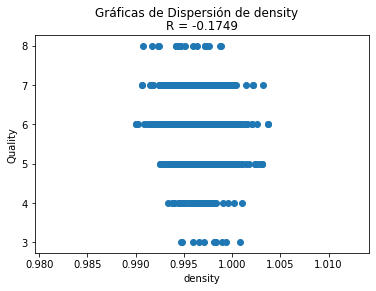

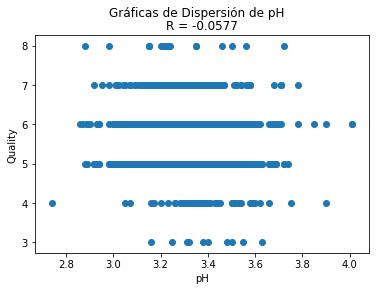

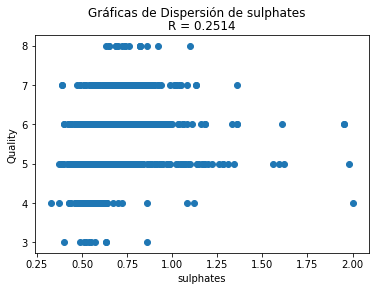

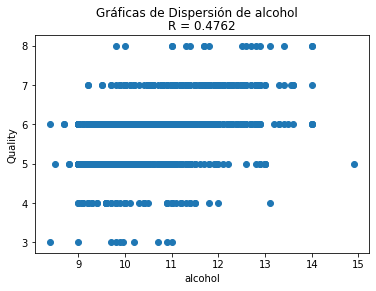

In [59]:
#Gráficas de dispersión para cada una de las variables independientes
for columna in data.columns:
    if(columna != 'quality'): #La variable "y" es la variable de intéres por lo cual es fija
        #calculamos el coeficiente de correlación de cada una de las variables independientes con respecto a la variable dependiente
        correlacion = round(data['quality'].corr(data[columna]),4)
        
        fig = plt.figure()
        fig.suptitle("Gráficas de Dispersión de " + columna)
        ax = fig.add_subplot(1,1,1)
        ax.scatter(data[columna], data["quality"])
        ax.set_xlabel(columna)
        ax.set_ylabel("Quality")
        ax.set_title('R = ' + str(correlacion))
    
plt.show()

##### Elección de Variables
Las tres variables independientes con mayor coeficiente de correlación, ya sea positiva o negativa (valor absoluto) son alcohol, volatile acidity y sulphates. 

Basados en las graficas y coeficientes de correlación, se ha decidido elegir las variables de alcohol y volatile acidity, ya que de acuerdo a su coeficiente de correlación, son las dos variables que mejor explican o estiman la calidad del vino.

##### Transformación de Variables
Generamos las combinaciones polinomiales para un polinomio de grado dos para las features que seleccionamos, las cuales son alcohol y volatile acidity.

 $[a,b,a^{2},b^{2},ab]$
 
 En donde $a=alcohol$ y $b=volatile$ $acidity$


In [60]:
#Obtenemos los valores para las variables independientes "x" y la variable dependiente "y"  del data frame de entrenamiento para usarlos en los experimentos
y_vino = df_entrenamiento['quality']
x_vino = df_entrenamiento[['alcohol','volatile acidity']]
x_vino

,alcohol,volatile acidity
0,9.4,0.700
1,9.8,0.880
2,9.8,0.760
3,9.8,0.280
4,9.4,0.700
...,...,...
1274,11.2,0.580
1275,9.5,0.715
1276,12.0,0.400
1277,9.7,0.690


In [61]:
#transformamos las variables dependientes
x_transformada = PolynomialFeatures(degree=2).fit_transform(x_vino).T
x_transformada

array([[  1.      ,   1.      ,   1.      , ...,   1.      ,   1.      ,
          1.      ],
       [  9.4     ,   9.8     ,   9.8     , ...,  12.      ,   9.7     ,
          9.5     ],
       [  0.7     ,   0.88    ,   0.76    , ...,   0.4     ,   0.69    ,
          0.715   ],
       [ 88.36    ,  96.04    ,  96.04    , ..., 144.      ,  94.09    ,
         90.25    ],
       [  6.58    ,   8.624   ,   7.448   , ...,   4.8     ,   6.693   ,
          6.7925  ],
       [  0.49    ,   0.7744  ,   0.5776  , ...,   0.16    ,   0.4761  ,
          0.511225]])

### 2. Aplicamos Regresión Lineal a las Variables Transformadas

In [62]:
#lr = 0.01, epochs= 1000
entrenamiento_rl(x_transformada, y_vino, 0.01, 1000,200,2)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Iteración: 200 , Parametros: [[nan nan nan nan nan nan]] , Error: nan
_______________________________________________________________________________________________________
Iteración: 400 , Parametros: [[nan nan nan nan nan nan]] , Error: nan
_______________________________________________________________________________________________________
Iteración: 600 , Parametros: [[nan nan nan nan nan nan]] , Error: nan
_______________________________________________________________________________________________________
Iteración: 800 , Parametros: [[nan nan nan nan nan nan]] , Error: nan
_______________________________________________________________________________________________________
Iteración: 1000 , Parametros: [[nan nan nan nan nan nan]] , Error: nan
_______________________________________________________________________________________________________


(array([[nan, nan, nan, nan, nan, nan]], dtype=float32), nan)

In [63]:
#lr = 0.001, epochs= 1000
entrenamiento_rl(x_transformada, y_vino, 0.001, 1000,200,2)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Iteración: 200 , Parametros: [[nan nan nan nan nan nan]] , Error: nan
_______________________________________________________________________________________________________
Iteración: 400 , Parametros: [[nan nan nan nan nan nan]] , Error: nan
_______________________________________________________________________________________________________
Iteración: 600 , Parametros: [[nan nan nan nan nan nan]] , Error: nan
_______________________________________________________________________________________________________
Iteración: 800 , Parametros: [[nan nan nan nan nan nan]] , Error: nan
_______________________________________________________________________________________________________
Iteración: 1000 , Parametros: [[nan nan nan nan nan nan]] , Error: nan
_______________________________________________________________________________________________________


(array([[nan, nan, nan, nan, nan, nan]], dtype=float32), nan)

In [64]:
#lr = 0.0001, epochs= 1000
entrenamiento_rl(x_transformada, y_vino, 0.0001, 1000,200,2)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Iteración: 200 , Parametros: [[0.00381334 0.02285553 0.00172661 0.04758912 0.00959271 0.00074296]] , Error: 0.5574203
_______________________________________________________________________________________________________
Iteración: 400 , Parametros: [[0.00707244 0.04045077 0.00310436 0.04562651 0.01581603 0.00125087]] , Error: 0.53916
_______________________________________________________________________________________________________
Iteración: 600 , Parametros: [[0.01021834 0.05743752 0.00436636 0.04376594 0.02110886 0.00166187]] , Error: 0.5225652
_______________________________________________________________________________________________________
Iteración: 800 , Parametros: [[0.01325791 0.07385264 0.00552309 0.04199948 0.02556394 0.00198586]] , Error: 0.50740093
_________________________________________________________________________________________________

(array([[0.01619743, 0.08972985, 0.00658406, 0.04031994, 0.02926533,
         0.00223182]], dtype=float32),
 0.49347162)

In [65]:
#lr = 0.00001, epochs= 1000
entrenamiento_rl(x_transformada, y_vino, 0.00001, 1000,200,2)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Iteración: 200 , Parametros: [[0.00077715 0.00646633 0.00037815 0.04944989 0.00311154 0.00019395]] , Error: 0.57541585
_______________________________________________________________________________________________________
Iteración: 400 , Parametros: [[0.00111948 0.00831408 0.00053332 0.04923854 0.00387517 0.0002595 ]] , Error: 0.573322
_______________________________________________________________________________________________________
Iteración: 600 , Parametros: [[0.00146054 0.01015501 0.00068711 0.04902836 0.0046276  0.00032387]] , Error: 0.57125014
_______________________________________________________________________________________________________
Iteración: 800 , Parametros: [[0.00180033 0.01198915 0.00083954 0.04881934 0.00536894 0.00038709]] , Error: 0.56920004
______________________________________________________________________________________________

(array([[0.00213888, 0.01381655, 0.00099063, 0.04861151, 0.0060993 ,
         0.00044916]], dtype=float32),
 0.56717116)

In [66]:
#lr = 0.0002, epochs= 1000
entrenamiento_rl(x_transformada, y_vino, 0.0002, 1000,200,2)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Iteración: 200 , Parametros: [[nan nan nan nan nan nan]] , Error: nan
_______________________________________________________________________________________________________
Iteración: 400 , Parametros: [[nan nan nan nan nan nan]] , Error: nan
_______________________________________________________________________________________________________
Iteración: 600 , Parametros: [[nan nan nan nan nan nan]] , Error: nan
_______________________________________________________________________________________________________
Iteración: 800 , Parametros: [[nan nan nan nan nan nan]] , Error: nan
_______________________________________________________________________________________________________
Iteración: 1000 , Parametros: [[nan nan nan nan nan nan]] , Error: nan
_______________________________________________________________________________________________________


(array([[nan, nan, nan, nan, nan, nan]], dtype=float32), nan)

In [67]:
#lr = 0.00001, epochs= 1000
entrenamiento_rl(x_transformada, y_vino, 0.00001, 1000,200,2)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Iteración: 200 , Parametros: [[0.00077715 0.00646633 0.00037815 0.04944989 0.00311154 0.00019395]] , Error: 0.57541585
_______________________________________________________________________________________________________
Iteración: 400 , Parametros: [[0.00111948 0.00831408 0.00053332 0.04923854 0.00387517 0.0002595 ]] , Error: 0.573322
_______________________________________________________________________________________________________
Iteración: 600 , Parametros: [[0.00146054 0.01015501 0.00068711 0.04902836 0.0046276  0.00032387]] , Error: 0.57125014
_______________________________________________________________________________________________________
Iteración: 800 , Parametros: [[0.00180033 0.01198915 0.00083954 0.04881934 0.00536894 0.00038709]] , Error: 0.56920004
______________________________________________________________________________________________

(array([[0.00213888, 0.01381655, 0.00099063, 0.04861151, 0.0060993 ,
         0.00044916]], dtype=float32),
 0.56717116)

In [68]:
#lr = 0.00001, epochs= 5000
entrenamiento_rl(x_transformada, y_vino, 0.00001, 5000,1000,2)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Iteración: 1000 , Parametros: [[0.00213888 0.01381655 0.00099063 0.04861151 0.0060993  0.00044916]] , Error: 0.56717116
_______________________________________________________________________________________________________
Iteración: 2000 , Parametros: [[0.00381306 0.022854   0.00172632 0.04758937 0.00959035 0.00074271]] , Error: 0.5573362
_______________________________________________________________________________________________________
Iteración: 3000 , Parametros: [[0.00545709 0.03172939 0.00243023 0.04659491 0.01282348 0.00100934]] , Error: 0.5479867
_______________________________________________________________________________________________________
Iteración: 4000 , Parametros: [[0.00707192 0.04044787 0.00310383 0.04562699 0.01581178 0.00125043]] , Error: 0.53908575
__________________________________________________________________________________________

(array([[0.00865846, 0.04901432, 0.00374852, 0.04468455, 0.01856771,
         0.00146732]], dtype=float32),
 0.5306)

In [69]:
#lr = 0.0001, epochs= 5000
entrenamiento_rl(x_transformada, y_vino, 0.0001, 5000,1000,2)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Iteración: 1000 , Parametros: [[0.01619743 0.08972985 0.00658406 0.04031994 0.02926533 0.00223182]] , Error: 0.49347162
_______________________________________________________________________________________________________
Iteración: 2000 , Parametros: [[0.02958132 0.16204982 0.01072806 0.03301504 0.03889495 0.00254995]] , Error: 0.4374773
_______________________________________________________________________________________________________
Iteración: 3000 , Parametros: [[0.04116102 0.22466008 0.01348442 0.02710756 0.03850867 0.00185723]] , Error: 0.3963851
_______________________________________________________________________________________________________
Iteración: 4000 , Parametros: [[0.05132224 0.27963054 0.01536676 0.02219014 0.03253362 0.00062315]] , Error: 0.36442515
__________________________________________________________________________________________

(array([[ 0.06033073,  0.32838848,  0.0166932 ,  0.01799998,  0.02364342,
         -0.00087056]], dtype=float32),
 0.33879885)

In [70]:
#lr = 0.0001, epochs= 10000
entrenamiento_rl(x_transformada, y_vino, 0.0001, 10000,2000,2)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Iteración: 2000 , Parametros: [[0.02958132 0.16204982 0.01072806 0.03301504 0.03889495 0.00254995]] , Error: 0.4374773
_______________________________________________________________________________________________________
Iteración: 4000 , Parametros: [[0.05132224 0.27963054 0.01536676 0.02219014 0.03253362 0.00062315]] , Error: 0.36442515
_______________________________________________________________________________________________________
Iteración: 6000 , Parametros: [[ 0.06837583  0.37195182  0.01766136  0.0143644   0.01343624 -0.00245718]] , Error: 0.31794178
_______________________________________________________________________________________________________
Iteración: 8000 , Parametros: [[ 0.08210284  0.44632912  0.01896939  0.00832819 -0.00756814 -0.00556558]] , Error: 0.28678554
_____________________________________________________________________________

(array([[ 0.0932909 ,  0.5070028 ,  0.01982286,  0.00350842, -0.02688391,
         -0.00834687]], dtype=float32),
 0.26565966)

In [71]:
#lr = 0.0001, epochs= 50000
entrenamiento_rl(x_transformada, y_vino, 0.0001, 50000,10000,2)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Iteración: 10000 , Parametros: [[ 0.0932909   0.5070028   0.01982286  0.00350842 -0.02688391 -0.00834687]] , Error: 0.26565966
_______________________________________________________________________________________________________
Iteración: 20000 , Parametros: [[ 0.1255081   0.68227875  0.02180682 -0.01020781 -0.08699615 -0.0169036 ]] , Error: 0.22729872
_______________________________________________________________________________________________________
Iteración: 30000 , Parametros: [[ 0.13763444  0.74906075  0.02241941 -0.0154127  -0.11030168 -0.02027285]] , Error: 0.22171365
_______________________________________________________________________________________________________
Iteración: 40000 , Parametros: [[ 0.14211853  0.77457404  0.02255093 -0.0174004  -0.11918098 -0.02162149]] , Error: 0.22090039
____________________________________________________________

(array([[ 0.1436877 ,  0.78433496,  0.02249897, -0.01816019, -0.12255209,
         -0.0221986 ]], dtype=float32),
 0.22078189)

In [72]:
#lr = 0.0001, epochs= 100000
entrenamiento_rl(x_transformada, y_vino, 0.0001, 100000,20000,2)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Iteración: 20000 , Parametros: [[ 0.1255081   0.68227875  0.02180682 -0.01020781 -0.08699615 -0.0169036 ]] , Error: 0.22729872
_______________________________________________________________________________________________________
Iteración: 40000 , Parametros: [[ 0.14211853  0.77457404  0.02255093 -0.0174004  -0.11918098 -0.02162149]] , Error: 0.22090039
_______________________________________________________________________________________________________
Iteración: 60000 , Parametros: [[ 0.14414205  0.78808445  0.02237827 -0.01845143 -0.12381978 -0.0224809 ]] , Error: 0.22076455
_______________________________________________________________________________________________________
Iteración: 80000 , Parametros: [[ 0.14403392  0.790156    0.02207396 -0.01861111 -0.12444942 -0.02277805]] , Error: 0.22076142
____________________________________________________________

(array([[ 0.1437359 ,  0.79032105,  0.02176761, -0.01862155, -0.1244578 ,
         -0.02298285]], dtype=float32),
 0.22076131)

Vemos que después de varios experimentos, el error sigue bajando pero muy lentamente, por lo cual se decidió realizar más pruebas, ahora con tres variables independientes, las tres variables que tienen mayor correlación (como se vió en la sección de Aánalisis exploratorio de datos"

In [73]:
#Obtenemos los valores para las variables independientes "x" y la variable dependiente "y"  del data frame de entrenamiento para usarlos en los experimentos
x_vino2 = df_entrenamiento[['alcohol','volatile acidity','sulphates']]
x_vino2

,alcohol,volatile acidity,sulphates
0,9.4,0.700,0.56
1,9.8,0.880,0.68
2,9.8,0.760,0.65
3,9.8,0.280,0.58
4,9.4,0.700,0.56
...,...,...,...
1274,11.2,0.580,0.53
1275,9.5,0.715,0.54
1276,12.0,0.400,0.56
1277,9.7,0.690,0.60


In [74]:
#transformamos las variables dependientes
x_transformada2 = PolynomialFeatures(degree=2).fit_transform(x_vino2).T
x_transformada2

array([[ 1.      ,  1.      ,  1.      , ...,  1.      ,  1.      ,
         1.      ],
       [ 9.4     ,  9.8     ,  9.8     , ..., 12.      ,  9.7     ,
         9.5     ],
       [ 0.7     ,  0.88    ,  0.76    , ...,  0.4     ,  0.69    ,
         0.715   ],
       ...,
       [ 0.49    ,  0.7744  ,  0.5776  , ...,  0.16    ,  0.4761  ,
         0.511225],
       [ 0.392   ,  0.5984  ,  0.494   , ...,  0.224   ,  0.414   ,
         0.3861  ],
       [ 0.3136  ,  0.4624  ,  0.4225  , ...,  0.3136  ,  0.36    ,
         0.2916  ]])

Se realiza el entrenamiento ahora con tres features

In [75]:
#lr = 0.0001, epochs= 100000
entrenamiento_rl(x_transformada2, y_vino, 0.0001, 100000,20000,2)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Iteración: 20000 , Parametros: [[ 0.1118945   0.608279    0.02111225  0.04194998 -0.0106154  -0.06432329
   0.09938533 -0.01314699 -0.0031614  -0.01963903]] , Error: 0.22391787
_______________________________________________________________________________________________________
Iteración: 40000 , Parametros: [[ 0.13127372  0.71544135  0.02243087  0.04262509 -0.01731557 -0.10054916
   0.07408877 -0.01815641 -0.00976092 -0.04937715]] , Error: 0.21513261
_______________________________________________________________________________________________________
Iteración: 60000 , Parametros: [[ 0.13499524  0.73797387  0.02264323  0.04071717 -0.018842   -0.10795597
   0.07197332 -0.01916515 -0.01334091 -0.07248396]] , Error: 0.21450305
_______________________________________________________________________________________________________
Iteración: 80000 , Parametros: [[ 0.1

(array([[ 0.13513857,  0.74321324,  0.02256719,  0.03579653, -0.019456  ,
         -0.10923139,  0.0785132 , -0.01930857, -0.01900869, -0.11461392]],
       dtype=float32),
 0.2140193)

In [76]:
#lr = 0.0001, epochs= 160000
entrenamiento_rl(x_transformada2, y_vino, 0.0001, 160000,20000,2)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Iteración: 20000 , Parametros: [[ 0.1118945   0.608279    0.02111225  0.04194998 -0.0106154  -0.06432329
   0.09938533 -0.01314699 -0.0031614  -0.01963903]] , Error: 0.22391787
_______________________________________________________________________________________________________
Iteración: 40000 , Parametros: [[ 0.13127372  0.71544135  0.02243087  0.04262509 -0.01731557 -0.10054916
   0.07408877 -0.01815641 -0.00976092 -0.04937715]] , Error: 0.21513261
_______________________________________________________________________________________________________
Iteración: 60000 , Parametros: [[ 0.13499524  0.73797387  0.02264323  0.04071717 -0.018842   -0.10795597
   0.07197332 -0.01916515 -0.01334091 -0.07248396]] , Error: 0.21450305
_______________________________________________________________________________________________________
Iteración: 80000 , Parametros: [[ 0.1

(array([[ 0.13372996,  0.7431974 ,  0.02232952,  0.02842045, -0.01988264,
         -0.10842139,  0.09004405, -0.01911216, -0.02702095, -0.1743807 ]],
       dtype=float32),
 0.21338122)

In [77]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 18148), started 1:06:10 ago. (Use '!kill 18148' to kill it.)

In [ ]:
%tensorboard --logdir logs

#### Grafo de Modelo

<img src="./Imagenes/grafo_modelo.png">

#### Gráficas del Costo o Error del Modelo

<img src="./Imagenes/error_modelo.png">

#### Conclusión
Como se puede observar en los experimentos, el mejor modelo, de acuerdo al menor error(mse) se obtiene utilizando las tres variables independientes con mayor correlación: **alcohol, volatile acidity y sulphates**  

Así mismo, los mejores hyper-parámetros de acuerdo a los experimentos son un **larning rate = 0.0001 y 100000 iteraciones**, con lo cual se obtiene un **mse de: 0.2140193**, el cual es un poco menor que el obtenido con estos mismos hyper'parámetros pero con dos features.  

Tanto cuando se utilizaron dos features, como cuando se usaron tres el error aún sigue disminuyendo si aumentamos las iteraciones, sin embargo es muy poco lo que baja, esto se puede eobservar en ambos casos después de la iteración 60000.  

En la imagen siguiente se seleccionaron los últimos tres experimentos, en los cuales vemos la disminución del error de usar dos y tres variables con los mismos hyper-párametros. Marcadas en rojo, con punto gris el modelo utilizando dos features y con punto rojo utilizando tres features
<img src="./Imagenes/detalle_error.png">